In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
happy = pd.read_csv('Happy countries 2017 survey.csv')
happy.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [139]:
#to check for missing values
happy.isnull().sum()

Country                          0
Happiness.Rank                   0
Happiness.Score                  0
Whisker.high                     0
Whisker.low                      0
Economy..GDP.per.Capita.         0
Family                           0
Health..Life.Expectancy.         0
Freedom                          0
Generosity                       0
Trust..Government.Corruption.    0
Dystopia.Residual                0
dtype: int64

In [140]:
#to check the data types of the features in the dataset
happy.dtypes

Country                           object
Happiness.Rank                     int64
Happiness.Score                  float64
Whisker.high                     float64
Whisker.low                      float64
Economy..GDP.per.Capita.         float64
Family                           float64
Health..Life.Expectancy.         float64
Freedom                          float64
Generosity                       float64
Trust..Government.Corruption.    float64
Dystopia.Residual                float64
dtype: object

<AxesSubplot:>

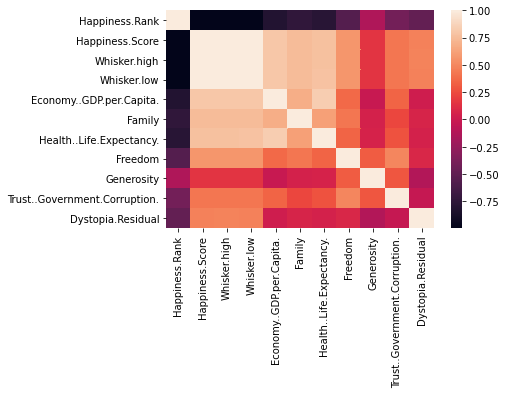

In [141]:
#to find the correlation between features
sns.heatmap(happy.corr())

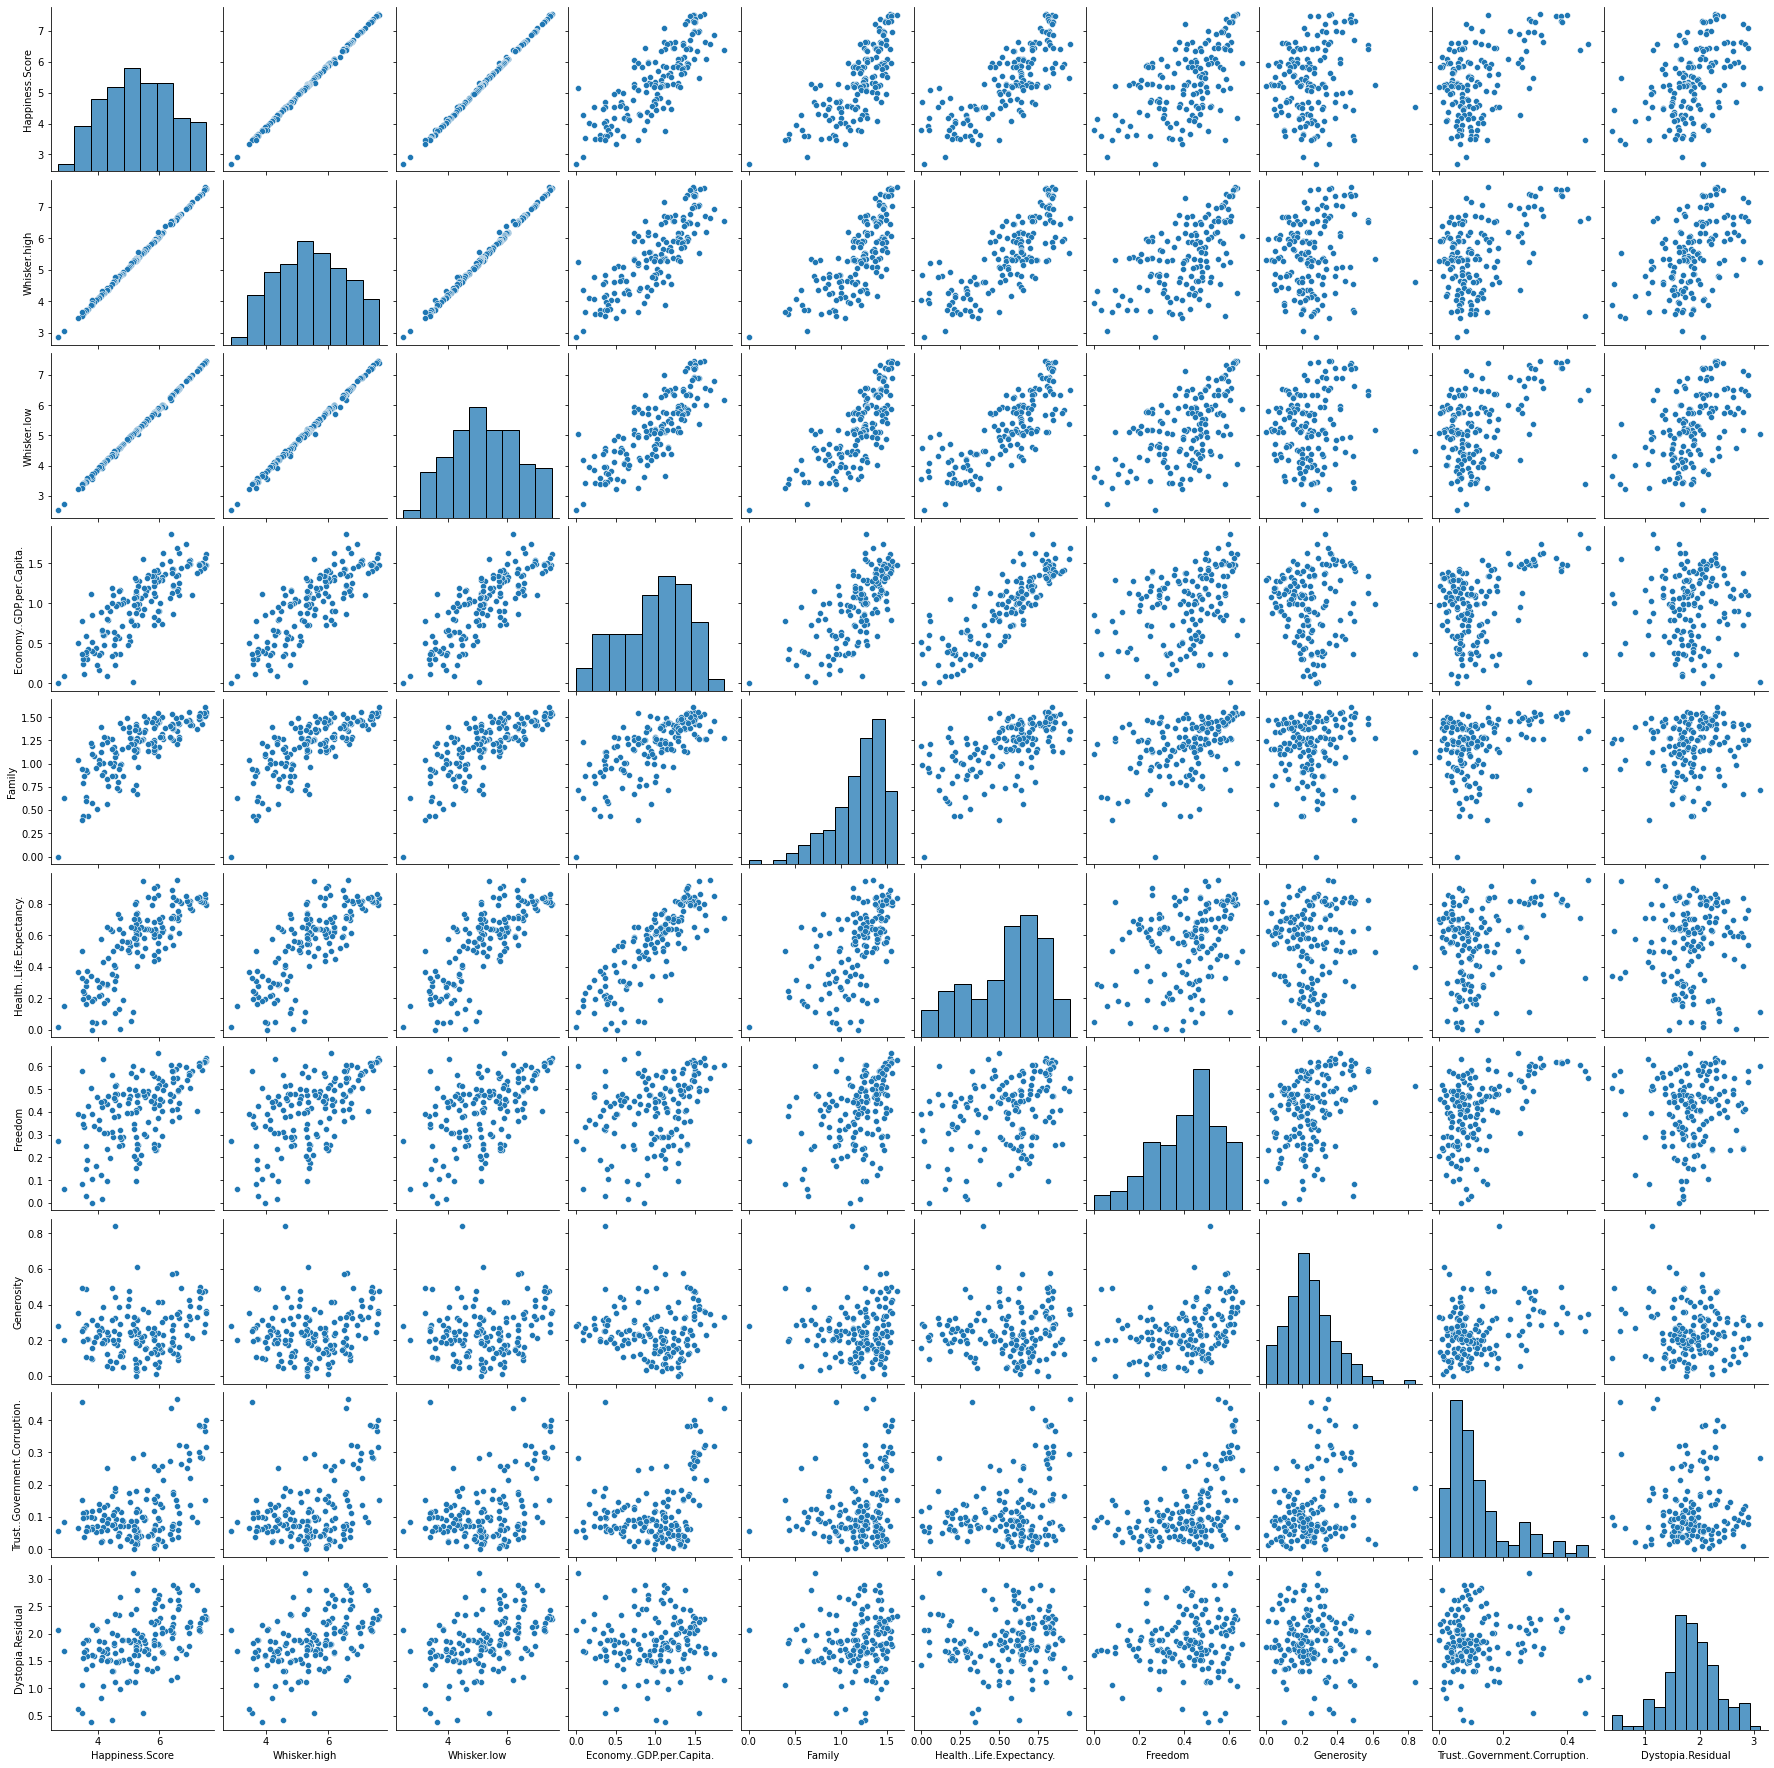

In [163]:
#to find the distribution of each feature in the dataset
sns.pairplot(happy)

In [142]:
#To drop the irrelevant features of the dataset
happy.drop(['Country', 'Happiness.Rank'], axis=1, inplace=True)
happy.head()

,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [143]:
#to separate the independent variables and dependent variables
X = happy.iloc[:,:-1]
y = happy.iloc[:,-1]

In [144]:
#Split the dataset into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [145]:
# make a prediction with a stacking ensemble
from numpy import mean, std
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [146]:
#Define the stacks of each level of the stacked model
def get_stacking():
    #define the base models
    level0 = list()
    level0.append(('ridge', Ridge()))
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('rr', RandomForestRegressor()))
    level0.append(('svr', SVR()))
    #define the meta model
    level1 = Ridge()

    #define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5).fit(X, y)
    
    return model

In [147]:
#list of models to evaluate
def get_models():
    models = dict()
    models['ridge'] = Ridge().fit(X_train, y_train)
    models['knn'] = KNeighborsRegressor().fit(X_train, y_train)
    models['rr'] = RandomForestRegressor().fit(X_train, y_train)
    models['svr'] = SVR().fit(X_train, y_train)
    models['stacking'] = get_stacking().fit(X_train, y_train)
    return models

In [148]:
#Evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [149]:
models = get_models()

In [150]:
#evaluate each model and store the results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>ridge -0.082 (0.022)
>knn -0.254 (0.080)
>rr -0.239 (0.055)
>svr -0.257 (0.069)
>stacking -0.050 (0.012)


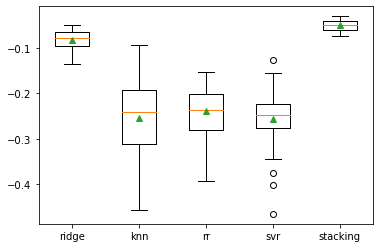

In [151]:
#plot the scores of the models
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Prediction of Test Data

In [154]:
y_pred_ridge = models['ridge'].predict(X_test)
y_pred_knn = models['knn'].predict(X_test)
y_pred_rr = models['rr'].predict(X_test)
y_pred_svr = models['svr'].predict(X_test)
y_pred_stacking = models['stacking'].predict(X_test)

### Model Performances

In [157]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [158]:
# predicting the accuracy score for Ridge Regression
score_ridge= r2_score(y_test,y_pred_ridge)
print('r2 score for Ridge Regression is: ',score_ridge)
print('mean_sqrd_error for Ridge Regression is: ',mean_squared_error(y_test,y_pred_ridge))
print('root_mean_squared error for Ridge Regression is: ',np.sqrt(mean_squared_error(y_test,y_pred_ridge)))

r2 score for Ridge Regression is:  0.9637388413190167
mean_sqrd_error for Ridge Regression is:  0.007652707374252482
root_mean_squared error for Ridge Regression is:  0.08747975408203022


In [159]:
# predicting the accuracy score for KNN Regression
score_knn= r2_score(y_test,y_pred_knn)
print('r2 score for KNN Regression is: ',score_knn)
print('mean_sqrd_error for KNN Regression is: ',mean_squared_error(y_test,y_pred_knn))
print('root_mean_squared error for KNN Regression is: ',np.sqrt(mean_squared_error(y_test,y_pred_knn)))

r2 score for KNN Regression is:  0.613879495720099
mean_sqrd_error for KNN Regression is:  0.08148849451968909
root_mean_squared error for KNN Regression is:  0.285461896791304


In [160]:
# predicting the accuracy score for Random Forest Regression
score_rr= r2_score(y_test,y_pred_rr)
print('r2 score for Random Forest Regression is: ',score_rr)
print('mean_sqrd_error for Random Forest Regression is: ',mean_squared_error(y_test,y_pred_rr))
print('root_mean_squared error for Random Forest Regression is: ',np.sqrt(mean_squared_error(y_test,y_pred_rr)))

r2 score for Random Forest Regression is:  0.3315931578311261
mean_sqrd_error for Random Forest Regression is:  0.14106339003306903
root_mean_squared error for Random Forest Regression is:  0.375584065201213


In [161]:
# predicting the accuracy score for Support Vector Regression
score_svr= r2_score(y_test,y_pred_svr)
print('r2 score for Support Vector Regression is: ',score_svr)
print('mean_sqrd_error for Support Vector Regression is: ',mean_squared_error(y_test,y_pred_svr))
print('root_mean_squared error for Support Vector Regression is: ',np.sqrt(mean_squared_error(y_test,y_pred_svr)))

r2 score for Support Vector Regression is:  0.4933760063272906
mean_sqrd_error for Support Vector Regression is:  0.10692005753212876
root_mean_squared error for Support Vector Regression is:  0.32698632621583545


In [162]:
# predicting the accuracy score for Stacked Regression
score_stacked = r2_score(y_test,y_pred_stacking)
print('r2 score for Stacked Regression is: ',score_stacked)
print('mean_sqrd_error for Stacked Regression is: ',mean_squared_error(y_test,y_pred_stacking))
print('root_mean_squared error for Stacked Regression is: ',np.sqrt(mean_squared_error(y_test,y_pred_stacking)))

r2 score for Stacked Regression is:  0.9865477276316502
mean_sqrd_error for Stacked Regression is:  0.002839024115567264
root_mean_squared error for Stacked Regression is:  0.05328249351867144


Since only Ridge Regression and Stacked model produces an r2 score of more than 0.8, only these models can be used for multiple linear regression.